LogReg | ROC-AUC=0.611 | PR-AUC=0.704
RandomForest | ROC-AUC=0.644 | PR-AUC=0.742
GBM | ROC-AUC=0.631 | PR-AUC=0.742

Mejor modelo (por PR-AUC): RandomForest

Mejor modelo (por PR-AUC): RandomForest

Umbral usado (Top 10%): 0.7736

Reporte de clasificación (Top 10% marcados como 1):
              precision    recall  f1-score   support

           0      0.434     0.974     0.600       312
           1      0.900     0.154     0.262       469

    accuracy                          0.481       781
   macro avg      0.667     0.564     0.431       781
weighted avg      0.714     0.481     0.397       781


Modelo guardado en 'modelo_churn_rf_v1.joblib'

Archivos generados:
- curva_pr.png
- scoring_clientes_test.csv


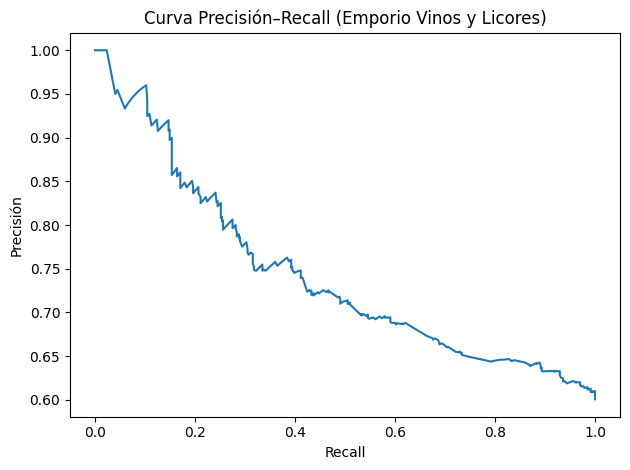

In [7]:
# ============================================================
# Evaluación 2 – Aplicaciones de IA
# Caso: Emporio Vinos y Licores – Predicción de no recompra (Churn 30 días)
# Integrantes: Carolina Parra · Diego Zambrano · Eduardo Noguera
# Ejecución:  python AI_Evaluacion2_EmporioChurn.py
# Requisitos: numpy, pandas, scikit-learn, matplotlib
# (en Colab: !pip install numpy pandas scikit-learn matplotlib)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    classification_report
)
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from joblib import dump, load

# -----------------------------
# 0) Simulación / Carga de datos
# -----------------------------
# Si tienes CSV reales, reemplaza la simulación por:
# users = pd.read_csv('users.csv', parse_dates=['signup_date'])
# orders = pd.read_csv('orders.csv', parse_dates=['order_date'])

RNG_SEED = 7
rng = np.random.default_rng(RNG_SEED)

n_users = 5000
users = pd.DataFrame({
    "user_id": np.arange(n_users),
    "signup_date": pd.Timestamp("2024-01-01") + pd.to_timedelta(rng.integers(0, 365, n_users), unit="D"),
    "region": rng.choice(["Norte","Centro","Sur"], n_users, p=[0.2,0.6,0.2]),
    "canal": rng.choice(["Tienda","Web","WhatsApp"], n_users, p=[0.5,0.4,0.1]),
})

orders_list = []
for uid in range(n_users):
    k = rng.integers(0, 11)  # 0..10 órdenes
    if k == 0:
        continue
    first = users.loc[uid, "signup_date"] + pd.to_timedelta(rng.integers(0, 45), unit="D")
    for j in range(k):
        d = first + pd.to_timedelta(rng.integers(0, 300), unit="D")
        amt = float(np.round(rng.gamma(2.5, 12.0), 2))
        cat = rng.choice(["Vino","Cerveza","Destilado","Accesorio"], p=[0.45,0.25,0.25,0.05])
        cup = int(rng.choice([0,1], p=[0.75,0.25]))
        orders_list.append([uid, f"{uid}-{j}", d, amt, cat, cup])

orders = pd.DataFrame(orders_list, columns=["user_id","order_id","order_date","amount","category","coupon_flag"])
if orders.empty:
    # Fallback mínimo
    orders = pd.DataFrame([[0,"0-0", pd.Timestamp("2024-02-01"), 45.0, "Vino", 0]],
                          columns=["user_id","order_id","order_date","amount","category","coupon_flag"])

# --------------------------------------
# 1) Definir snapshot y etiqueta churn
# --------------------------------------
snapshot = pd.Timestamp("2024-12-01")

# Agregados por cliente hasta snapshot
base = (orders[orders["order_date"] <= snapshot]
        .sort_values(["user_id","order_date"])
        .groupby("user_id", as_index=False)
        .agg(last_date=("order_date","max"),
             freq_180=("order_id","count"),
             spend_total=("amount","sum"),
             spend_avg=("amount","mean"),
             coupon_rate=("coupon_flag","mean")))

# ¿compra dentro de 30 días después del snapshot?
future = orders[orders["order_date"].between(snapshot, snapshot + timedelta(days=30))]
rebuy_users = set(future["user_id"].unique())
base["churn_30d"] = (~base["user_id"].isin(rebuy_users)).astype(int)  # 1 = no recompra (churn)

# --------------------------------------
# 2) Ingeniería de variables (features)
# --------------------------------------
feat = base.merge(users, on="user_id", how="left")

feat["recency_days"] = (snapshot - feat["last_date"]).dt.days
feat["tenure_days"]  = (snapshot - feat["signup_date"]).dt.days.clip(lower=0)
feat["arpu"] = feat["spend_total"] / (feat["tenure_days"]/30 + 1e-9)

# Mezcla de categorías (% por cliente)
cat_share = (orders[orders["order_date"] <= snapshot]
             .pivot_table(index="user_id", columns="category", values="amount", aggfunc="sum", fill_value=0))
cat_share = cat_share.div(cat_share.sum(axis=1).replace(0,1), axis=0).add_prefix("share_").reset_index()
feat = feat.merge(cat_share, on="user_id", how="left").fillna(0)

# One-hot mínimo para variables categóricas
feat = pd.get_dummies(feat, columns=["region","canal"], drop_first=True)

# --------------------------------------
# 3) Conjunto final y split
# --------------------------------------
target = "churn_30d"
drop_cols = ["user_id","signup_date","last_date",target]
feature_cols = [c for c in feat.columns if c not in drop_cols]

X = feat[feature_cols].copy().fillna(0)
y = feat[target].copy()

# Estratificado por clase
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# --------------------------------------
# 4) Modelos y calibración de probabilidades
# --------------------------------------
models = {
    "LogReg": Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", LogisticRegression(max_iter=300, n_jobs=None))
    ]),
    "RandomForest": RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1),
    "GBM": GradientBoostingClassifier(random_state=42)
}

results = []
probas = {}
fitted_models = {}  # 🔹 aquí vamos a ir guardando cada modelo calibrado

for name, base_model in models.items():
    # Para consistencia, calibramos todos con isotónica
    calibrated = CalibratedClassifierCV(base_model, cv=3, method="isotonic")
    calibrated.fit(X_train, y_train)
    p = calibrated.predict_proba(X_test)[:, 1]

    probas[name] = p
    fitted_models[name] = calibrated  # 🔹 guardamos el modelo entrenado

    auc = roc_auc_score(y_test, p)
    ap  = average_precision_score(y_test, p)
    results.append((name, auc, ap))
    print(f"{name} | ROC-AUC={auc:.3f} | PR-AUC={ap:.3f}")

# Ordenar por PR-AUC (mejor primero)
results_sorted = sorted(results, key=lambda t: t[2], reverse=True)
best_name, best_auc, best_ap = results_sorted[0]
print("\nMejor modelo (por PR-AUC):", best_name)

# 🔹 Recuperar el mejor modelo ya entrenado
best_model = fitted_models[best_name]


# Ordenar por PR-AUC (mejor primero)
results_sorted = sorted(results, key=lambda t: t[2], reverse=True)
best_name, best_auc, best_ap = results_sorted[0]
print("\nMejor modelo (por PR-AUC):", best_name)

# --------------------------------------
# 5) Reporte con umbral (Top 10% riesgo)
# --------------------------------------
p = probas[best_name]
threshold = float(np.quantile(p, 0.90))
y_pred_top10 = (p >= threshold).astype(int)

print("\nUmbral usado (Top 10%):", round(threshold, 4))
print("\nReporte de clasificación (Top 10% marcados como 1):")
print(classification_report(y_test, y_pred_top10, digits=3))

# Guardar artefacto del modelo para producción (MLOps)
artifact = {
    "model": best_model,
    "feature_cols": feature_cols,
    "threshold_top10": threshold,
}

dump(artifact, "modelo_churn_rf_v1.joblib")
print("\nModelo guardado en 'modelo_churn_rf_v1.joblib'")


# --------------------------------------
# 6) Curva Precisión-Recall y export
# --------------------------------------
prec, rec, _ = precision_recall_curve(y_test, p)
plt.figure()
plt.plot(rec, prec)
plt.title("Curva Precisión–Recall (Emporio Vinos y Licores)")
plt.xlabel("Recall")
plt.ylabel("Precisión")
plt.tight_layout()
plt.savefig("curva_pr.png", dpi=140)

scored = pd.DataFrame({
    "proba_churn": p,
    "y_true": y_test.reset_index(drop=True)
})
scored.to_csv("scoring_clientes_test.csv", index=False)

print("\nArchivos generados:")
print("- curva_pr.png")
print("- scoring_clientes_test.csv")
